In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import shutil
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-09-11 11:17:23


In [3]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2005,2017)
MaxOpenProcesses = 15

Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool'
Project_GDB  = Project_DIR + '\\2.Project_GDB.gdb'
ContractsDir = Project_DIR + '\\4.Contracts_AnalysisFiles'
DocumentsDir = Project_DIR + '\\5.Documents'
PythonDir    = Project_DIR + '\\6.Python_Codes'
ReceivedDir  = Project_DIR + '\\7.ReceivedData'
XML_Dir      = ReceivedDir + '\\HSIP Candidate Applications'


# IRIS Dataset
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
IRISPath = r'C:\Users\mr068144\Downloads\IL Data\IRIS\IL_IRIS.gdb'
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route') for y in Years}
IRIS_Tab   = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table_HCurve') for y in Years}
IRIS_Tab[2012] = IRIS_Tab[2013]

# Intersections Dataset
IntPG = r'C:\Users\mr068144\Downloads\6.0_Intersection_Layer\IRIS_Ints.gdb\Int2014_PG'
Intersections = {year:IntPG for year in Years}

#Crash Dataset
CrashData  = {y:os.path.abspath(r'C:\Users\mr068144\Downloads\IL Data\IL Crash Data\IL_Crash.gdb\\' +
                          'CrashExtract_' + str(y) + '_GIS') for y in Years}

Fields = ['AADT',
          'O_SHD1_TYP','O_SHD1_WTH','O_SHD2_TYP','O_SHD2_WTH',
          'I_SHD1_TYP','I_SHD1_WTH','I_SHD2_TYP','I_SHD2_WTH',
          'LNS','LN_WTH','MED_TYP','MED_WTH','SURF_WTH','URBAN','PG','Radius','CurveLen']
#Fields = ['AADT','URBAN','PG']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

# Geocoded projects
HSIP_Int  = Project_GDB + '\\WPPS_Int'
HSIP_Seg  = Project_GDB + '\\WPPS_Seg'

HSIP_Path    = ReceivedDir + '\\HSIP_AllApprovedProjects.xlsm'
WPPS_Ob_Path = ReceivedDir + '\\HSIP Contract and Obligation Data.xlsx'
WPPS_Pr_Path = ReceivedDir + '\\HSIP Project Programmed Data.xlsx'
SPF_Data     = ReceivedDir  + '\\SPF Coefficients.xlsx'

2018-09-11 11:17:23


In [7]:
print(hsmpy3.common.PrintSummary(IRIS_Route[2016]))
[f.name for f in arcpy.ListFields(IRIS_Tab[2016])]

Type: Polyline
Columns: 4 x Rows: 214692
['INVENTORY', 'OBJECTID', 'Shape', 'Shape_Length']
{'Columns': ['INVENTORY', 'OBJECTID', 'Shape', 'Shape_Length'], 'ShapeType': 'Polyline', 'Rows': 214692}


['OBJECTID',
 'INVENTORY',
 'BEG_STA',
 'END_STA',
 'OBJECTID_1',
 'AADT',
 'AADT_YR',
 'AADT_EST',
 'ACC_CNTL',
 'BLT',
 'CH',
 'CO_ADJ',
 'CONG',
 'CONG_ADJ',
 'CRS_LOW',
 'CRS_OPP',
 'CRS_WITH',
 'CRS_YR',
 'DIST',
 'DTRESS_OPP',
 'DTRESS_WTH',
 'FAULT_LOW',
 'FAULT_OPP',
 'FAULT_WITH',
 'FC',
 'HCV',
 'HCV_MU_YR',
 'I_SHD1_TYP',
 'I_SHD1_WTH',
 'I_SHD2_TYP',
 'I_SHD2_WTH',
 'INV_CO',
 'IRI_LOW',
 'IRI_OPP',
 'IRI_WITH',
 'JUR_1',
 'JUR_2',
 'JUR_TYPE',
 'KEY_RT_APN',
 'KEY_RT_APP',
 'KEY_RT_NBR',
 'KEY_RT_SEG',
 'KEY_RT_SUF',
 'KEY_RT_TYP',
 'LN_SPC',
 'LN_SPC_NBR',
 'LN_SPC_WTH',
 'LN_WTH',
 'LNS',
 'MAINT_TYPE',
 'MARKED_RT',
 'MARKED_RT2',
 'MARKED_RT3',
 'MARKED_RT4',
 'MED_TYP',
 'MED_WTH',
 'MNT_1',
 'MNT_2',
 'MNT_DIST',
 'MNT_SECT',
 'MRK_RT_TY2',
 'MRK_RT_TY3',
 'MRK_RT_TY4',
 'MRK_RT_TYP',
 'MU_VOL',
 'MU_EST',
 'MUNI',
 'MUNI_ADJ',
 'NHS',
 'NON_ATTAIN',
 'O_SHD1_TYP',
 'O_SHD1_WTH',
 'O_SHD2_TYP',
 'O_SHD2_WTH',
 'OP_1_2_WAY',
 'PL_AGY',
 'PL_AGY_ADJ',
 'PRK_LT',
 'PRK_

In [38]:
df = hsmpy3.common.FCtoDF(IRIS_Tab[2016],selectedFields=['INVENTORY','BEG_STA','END_STA',
                                                    'INV_CO',
                                                    'KEY_RT_SEG',
                                                    'KEY_RT_TYP',
                                                    'KEY_RT_NBR',
                                                    'KEY_RT_SUF',
                                                    'KEY_RT_APP',
                                                   'KEY_RT_APN'])
df.index = df.INVENTORY
df['BMP'] = pd.DataFrame(df.groupby('INVENTORY')['BEG_STA'].aggregate(min)).loc[df.index]
df['EMP'] = pd.DataFrame(df.groupby('INVENTORY')['END_STA'].aggregate(max)).loc[df.index]
df = df[['BMP','EMP','INV_CO','KEY_RT_SEG','KEY_RT_TYP','KEY_RT_NBR','KEY_RT_SUF','KEY_RT_APP','KEY_RT_APN']]
df = df.drop_duplicates()
df.loc[df.KEY_RT_TYP==' ','KEY_RT_TYP'] = 0
df.INV_CO = df.INV_CO.astype(int)
df.KEY_RT_TYP = df.KEY_RT_TYP.astype(int)
df.KEY_RT_NBR = df.KEY_RT_NBR.astype(int)
df.KEY_RT_APP = df.KEY_RT_APP.astype(int)
df.loc[df.KEY_RT_APN==' ','KEY_RT_APN'] = 0
df.KEY_RT_APN = df.KEY_RT_APN.astype(int)
print(df.shape)

(635792, 9)


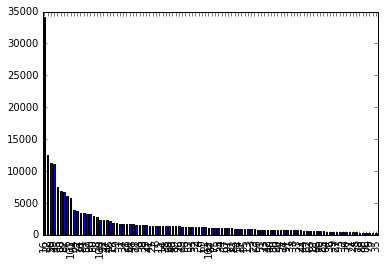

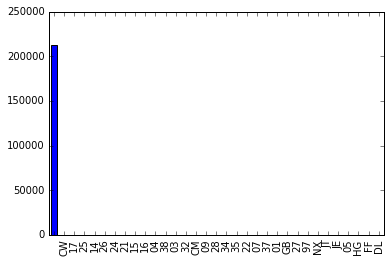

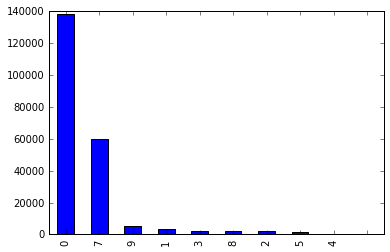

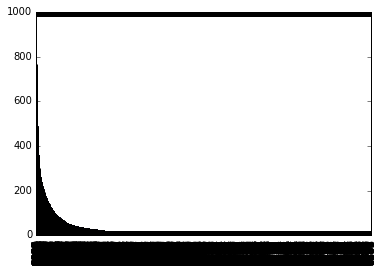

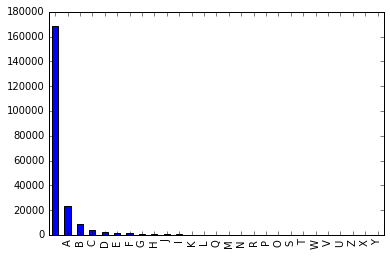

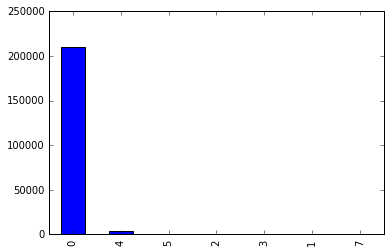

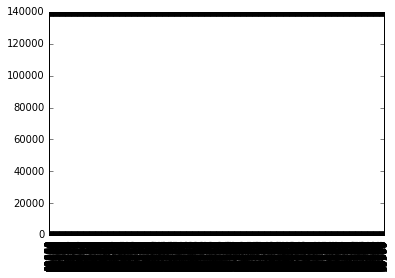

In [34]:
df.INV_CO.value_counts().plot(kind='bar')
plt.show()
df.KEY_RT_SEG.value_counts().plot(kind='bar')
plt.show()
df.KEY_RT_TYP.value_counts().plot(kind='bar')
plt.show()
df.KEY_RT_NBR.value_counts().plot(kind='bar')
plt.show()
df.KEY_RT_SUF.value_counts().plot(kind='bar')
plt.show()
df.KEY_RT_APP.value_counts().plot(kind='bar')
plt.show()
df.KEY_RT_APN.value_counts().plot(kind='bar')
plt.show()

In [67]:
df[(df.KEY_RT_TYP==2) & (df.KEY_RT_NBR==345) & (df.KEY_RT_APP==0)]

HWY2016_table_HCurve,BMP,EMP,INV_CO,KEY_RT_SEG,KEY_RT_TYP,KEY_RT_NBR,KEY_RT_SUF,KEY_RT_APP,KEY_RT_APN
INVENTORY,,,,,,,,,
016 20345 000000,0.0,6.66,016,,2,345,,0,0
016 20345A000000,0.0,4.22,016,,2,345,A,0,0
016 20345B000000,0.0,14.44,016,,2,345,B,0,0
022 20345 000000,0.0,1.35,022,,2,345,,0,0
022 20345A000000,0.0,2.35,022,,2,345,A,0,0
022 20345B000000,0.0,5.75,022,,2,345,B,0,0
045 20345 000000,0.0,5.07,045,,2,345,,0,0
045 20345A000000,0.0,11.57,045,,2,345,A,0,0
